In [1]:
import pandas as pd
from helpers import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk import FreqDist
import operator
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

/home/vecht499/.local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

## Load dataset & process it

In [3]:
df = pd.read_csv("../data/Reviews.csv")
df.columns = map(lambda x: x.lower(), df.columns)
## remove neutral reviews
df=df[df.score!=3].copy()

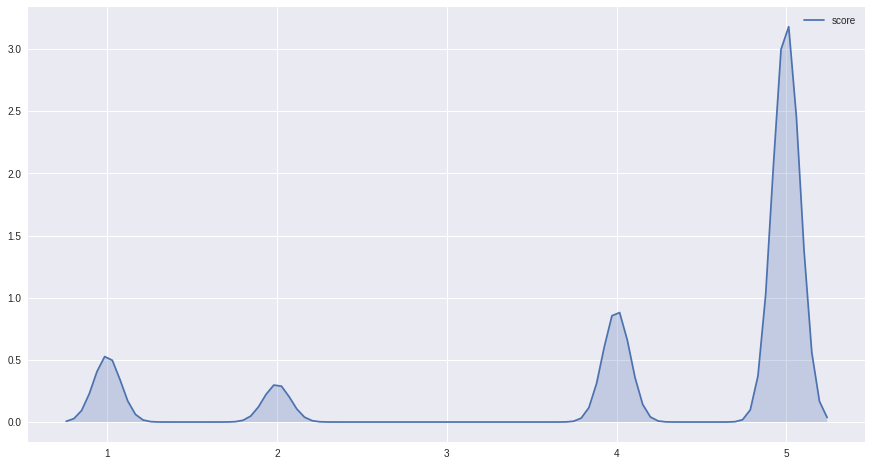

In [4]:
## score distribution
plt.figure(figsize=(15,8))
sns.kdeplot(df.score, shade=True)

In [5]:
df = df[pd.notnull(df.text)].reset_index(drop=True).copy()

In [6]:
df["text"] = df["text"].apply(lambda x: cleanData(x))
df["negative"] = df["score"].apply(lambda x: 1 if x<3 else 0)
df["text_length"] = df["text"].apply(lambda x: getSentenceLength(x))

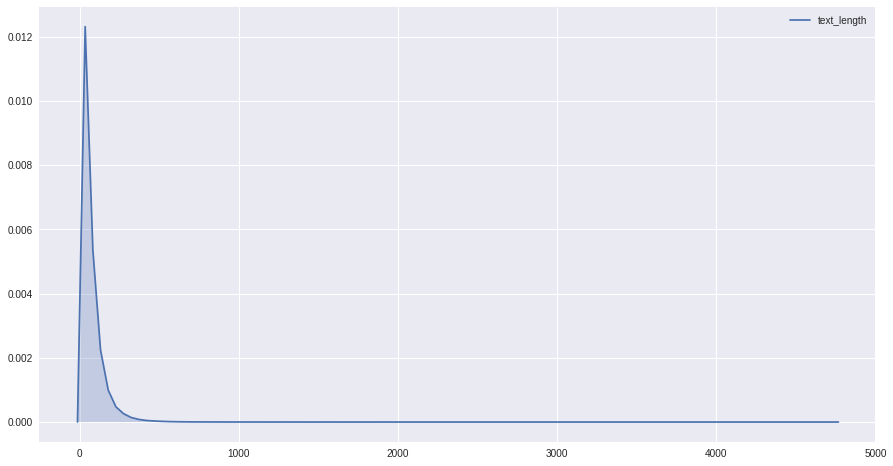

In [7]:
## review length distribution
plt.figure(figsize=(15,8))
sns.kdeplot(df.text_length, shade=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348617 entries, 0 to 1348616
Data columns (total 11 columns):
productid      1348617 non-null object
title          1348162 non-null object
userid         1348617 non-null object
helpfulness    1348617 non-null object
score          1348617 non-null float64
text           1348617 non-null object
cat1           1348617 non-null object
cat2           1348617 non-null object
cat3           1348617 non-null object
negative       1348617 non-null int64
text_length    1348617 non-null int64
dtypes: float64(1), int64(2), object(8)
memory usage: 113.2+ MB


In [9]:
## remove reviews with length more than 100
df = df[df.text_length<=100].copy()
## if length of a review is shorter than 100; fill it in with placeholer words
df["text_adj"] = df["text"].apply(lambda x: add_placeholders(x,100))

In [10]:
df.head(2)

,productid,title,userid,helpfulness,score,text,cat1,cat2,cat3,negative,text_length,text_adj
0,B0000DF3IX,Paprika Hungarian Sweet,A244MHL2UN2EYL,0/0,5.0,while in hungary we were given a recipe for hu...,grocery gourmet food,herbs,spices seasonings,0,32,while in hungary we were given a recipe for hu...
1,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A3FL7SXVYMC5NR,3/3,5.0,without a doubt i would recommend this wholeso...,grocery gourmet food,breakfast foods,cereals,0,38,without a doubt i would recommend this wholeso...


In [11]:
df = df.sample(n=200000, random_state=0).copy()

In [12]:
## create word count dictionary for all reviews
word_dist = FreqDist()
for s in df.text_adj:
    word_dist.update(s.split())

## replace rare words (occur only once)
words_to_replace = [k for k, v in word_dist.items() if v == 1]

word_lookup = {}
for word in word_dist.keys():
    if word in words_to_replace:
        word_lookup[word] = "rareword"
    else:
        word_lookup[word] = word

def replace_words(strg, words_to_replace):
    line = strg.split()
    line = [word_lookup[x] for x in line]
    result = ' '.join(line)
    return result

df["text_adj"] = df["text_adj"].apply(lambda x: replace_words(x, words_to_replace))

In [13]:
## create word count dictionary for all reviews
word_dist = FreqDist()
for s in df.text_adj:
    word_dist.update(s.split())

## take a look at dictionary
sorted_x = sorted(word_dist.items(), key=operator.itemgetter(1))
print(sorted_x)

[('inbuilt', 2), ('charly', 2), ('compromises', 2), ('orientals', 2), ('toenjoy', 2), ('eldar', 2), ('bery', 2), ('travle', 2), ('downrange', 2), ('dats', 2), ('parle', 2), ('munich', 2), ('comit', 2), ('woop', 2), ('airfresh', 2), ('spat', 2), ('saunier', 2), ('vineyard', 2), ('reilly', 2), ('shutes', 2), ('bloodstains', 2), ('cia', 2), ('admitt', 2), ('gators', 2), ('palying', 2), ('intricately', 2), ('notan', 2), ('affiliates', 2), ('veggy', 2), ('wis', 2), ('beanbag', 2), ('tog', 2), ('wieder', 2), ('practiclly', 2), ('serendipitous', 2), ('scummy', 2), ('sickthanks', 2), ('turnovers', 2), ('andim', 2), ('wipey', 2), ('fews', 2), ('bitterly', 2), ('shild', 2), ('recommande', 2), ('coladas', 2), ('interlocked', 2), ('doctored', 2), ('nutraments', 2), ('wilt', 2), ('uncertainty', 2), ('edtion', 2), ('kilogram', 2), ('gasy', 2), ('consecutively', 2), ('kups', 2), ('everyother', 2), ('hairit', 2), ('streached', 2), ('stange', 2), ('pelaje', 2), ('obligation', 2), ('empece', 2), ('mandi

In [14]:
vocab = {}
for e,y in enumerate(word_dist.keys()):
    vocab[y]=e

In [15]:
len(vocab)

39926

In [16]:
vocab

{'trees': 0,
 'moses': 1,
 'toner': 2,
 'nighttime': 3,
 'geoffrey': 8036,
 'bodyfat': 5,
 'disapointing': 6,
 'insane': 7,
 'blankets': 8,
 'vice': 9,
 'inbuilt': 10,
 'depresses': 11,
 'snoozer': 12,
 'eta': 25157,
 'vader': 13,
 'peach': 34848,
 'coin': 39743,
 'affected': 15,
 'effortlessly': 16,
 'compromises': 17,
 'rushed': 18,
 'orientals': 19,
 'additive': 20,
 'seing': 34594,
 'probally': 6575,
 'mono': 23,
 'bulge': 26,
 'rap': 27,
 'bery': 28,
 'sugarfree': 29,
 'question': 30,
 'digestive': 12324,
 'corrosion': 32,
 'entertained': 33,
 'travis': 35,
 'bay': 36,
 'mail': 34067,
 'piggy': 37,
 'excerise': 38,
 'downrange': 39,
 'dats': 41,
 'notebook': 42,
 'parle': 44,
 'woven': 45,
 'munich': 46,
 'brittle': 47,
 'roomier': 48,
 'comit': 49,
 'grosses': 50,
 'gunner': 51,
 'excreted': 52,
 'saskatoon': 53,
 'wrinkled': 54,
 'brilliant': 55,
 'twiins': 56,
 'repetitive': 58,
 'mot': 59,
 'regarding': 33227,
 'closing': 62,
 'feta': 6579,
 'outliner': 63,
 'straped': 13953,


In [17]:
## map each sentence to a vector of words:
sentence_vecs = np.array(df["text_adj"].apply(lambda x: create_sentence_vectors(x, vocab)).tolist())

## try translation table instead(?)

In [18]:
sentence_vecs

array([[25203, 22775, 20994, ..., 16360, 16360, 16360],
       [13634, 15276, 13153, ..., 16360, 16360, 16360],
       [36797, 19503, 25031, ..., 16360, 16360, 16360],
       ..., 
       [ 9040, 34536, 12797, ..., 16360, 16360, 16360],
       [33720, 20974,  4201, ..., 16360, 16360, 16360],
       [19503, 13961,  3480, ..., 16360, 16360, 16360]])

In [19]:
label_vecs = np.array(df.negative.tolist())

In [20]:
## train-valid-test split
train_dataset, test_dataset, train_labels, test_labels = \
                            train_test_split(sentence_vecs, label_vecs, test_size=0.3, random_state=0)
test_dataset, valid_dataset, test_labels, valid_labels = \
                            train_test_split(test_dataset, test_labels, test_size=0.33, random_state=0)

In [21]:
print ("Size of train set: %s" % len(train_dataset))
print ("Size of test set: %s" % len(test_dataset))
print ("Size of validation set: %s" % len(valid_dataset))

Size of train set: 140000
Size of test set: 40200
Size of validation set: 19800


In [22]:
train_dataset, train_labels

(array([[33720, 27458, 10771, ..., 16360, 16360, 16360],
        [ 5740, 12648, 32870, ..., 16360, 16360, 16360],
        [15394,  7293, 29564, ..., 16360, 16360, 16360],
        ..., 
        [ 9040, 19961,  2414, ..., 16360, 16360, 16360],
        [ 9040, 12797, 20792, ..., 16360, 16360, 16360],
        [19503, 17952,  9040, ..., 16360, 16360, 16360]]),
 array([0, 0, 0, ..., 0, 0, 0]))

## Ready for tensorflow!

In [23]:
SEQ_LENGTH = 100
BATCH_SIZE = 50
NUM_LABELS = 2

VOCAB_SIZE = len(vocab)
EMBED_SIZE = 128

FILTER_SIZE_1 = 3
FILTER_SIZE_2 = 4
FILTER_SIZE_3 = 5
NUM_FILTERS = 128

keep_prob = 0.8

tf_train_dataset = tf.placeholder(tf.int32, shape=(BATCH_SIZE, SEQ_LENGTH), name="input_x")
tf_train_labels = tf.placeholder(tf.int32, shape=(BATCH_SIZE), name="input_y")
tf_valid_dataset = tf.constant(valid_dataset) 
tf_test_dataset = tf.constant(test_dataset)

# Keeping track of l2 regularization loss (optional)
#l2_loss = tf.constant(0.0)

## Embedding layer

embed_weigths = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMBED_SIZE], -1.0, 1.0))
    
## Convolutional layers
## Change to True if run again
with tf.variable_scope("vars", reuse = None):
    
    conv1_weights = tf.get_variable("conv1_w", shape=[FILTER_SIZE_1, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv1_b")

    conv2_weights = tf.get_variable("conv2_w", shape=[FILTER_SIZE_2, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv2_b")

    conv3_weights = tf.get_variable("conv3_w", shape=[FILTER_SIZE_3, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv3_b")

## Fully connected layer

    fc1_weights = tf.get_variable("fc1_w", shape=[3*NUM_FILTERS, NUM_LABELS],\
                                                initializer=tf.contrib.layers.xavier_initializer())
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]), name = "fc1_b")

# Model:
def model(data, keep_prob = keep_prob): 
    
    ## Embedding layer
    ## input shape:[BATCH_SIZE, SEQ_LENGTH]
    ## output shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    
    with tf.device('/cpu:0'), tf.name_scope("word2vec_embedding"):    
        embed_chars = tf.nn.embedding_lookup(embed_weigths, data)
        embed_chars = tf.expand_dims(embed_chars, -1)
    
    ## Conv1+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv1-maxpool-3"):
        conv1 = tf.nn.conv2d(embed_chars, conv1_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
        pool1 = tf.nn.max_pool(relu1, ksize=[1, SEQ_LENGTH-FILTER_SIZE_1+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    ## Conv2+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv2-maxpool-4"):
        conv2 = tf.nn.conv2d(embed_chars, conv2_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
        pool2 = tf.nn.max_pool(relu2, ksize=[1, SEQ_LENGTH-FILTER_SIZE_2+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    
    ## Conv3+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv3-maxpool-5"):
        conv3 = tf.nn.conv2d(embed_chars, conv3_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
        pool3 = tf.nn.max_pool(relu3, ksize=[1, SEQ_LENGTH-FILTER_SIZE_3+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    
    ## Combine pooled features + flatten
    ## input shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    ## output shape: [BATCH_SIZE, 3, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("combine_flatten"):
        pooled_outputs = [pool1, pool2, pool3]
        h_pool = tf.concat(pooled_outputs,3)
        h_pool_flat = tf.reshape(h_pool, [-1, NUM_FILTERS*3])
    
    with tf.name_scope("dropout"):
        h_pool_flat = tf.nn.dropout(h_pool_flat, keep_prob)
    
    ## Fully connected layer
    with tf.name_scope("output"):
        return tf.matmul(h_pool_flat, fc1_weights) + fc1_biases  
  
#Training computation:
logits = model(tf_train_dataset)
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
# Optimizer:
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

# with tf.name_scope("output"):
#            W = tf.get_variable(
#                "W",
#                shape=[num_filters_total, num_classes],
#                initializer=tf.contrib.layers.xavier_initializer())
#            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
#            l2_loss += tf.nn.l2_loss(W)
#            l2_loss += tf.nn.l2_loss(b)
#            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
#            self.predictions = tf.argmax(self.scores, 1, name="predictions")
#
#        # CalculateMean cross-entropy loss
#        with tf.name_scope("loss"):
#            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
#            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


In [24]:
## remove objects from memory
del word_dist
del word_lookup

**Predictions for the training, validation, and test data**

In [25]:
train_prediction = tf.nn.softmax(logits)
valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
test_prediction = tf.nn.softmax(model(tf_test_dataset))

## Train model and report accuracy

In [26]:
NUM_ITERATIONS =5001

step = []
pred = []
loss_minibatch = []
accuracy_minibatch = []
accuracy_valid = []

logs_path = '../tensorflow_logs/example'

with tf.Session() as session:
    tf.global_variables_initializer().run()
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for i in range(NUM_ITERATIONS):
        offset = (i * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
        
        if (i % 200 == 0): ## info will be printed every 1000th time
            #predictions = np.argmax(predictions, 1)
            step.append(i)
            print("Minibatch loss at step %d: %f" % (i, l))
            loss_minibatch.append(l)
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            accuracy_minibatch.append(accuracy(predictions, batch_labels))
            #print("Minibatch f1 score: %.1f%%" % f1_score(predictions, batch_labels))
            #accuracy_minibatch.append(f1_score(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
            accuracy_valid.append(accuracy(valid_prediction.eval(), valid_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
            #accuracy_valid.append(accuracy(valid_prediction.eval(), valid_labels))
            
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    
    #save_path = saver.save(session, "../models/SVHN_MODEL.ckpt")
    #print("Model saved in file: %s" % save_path)
    
    #pred.append(test_prediction.eval(), 1)
    
    print("Run the command line:\n" \
          "--> tensorboard --logdir=path_to_logs/tensorflow_logs " \
          "\nThen open http://172.26.179.29:6006/ into your web browser")
    
#from sklearn.metrics import precision_score
#from sklearn.metrics import recall_score
#from sklearn.metrics import f1_score
#from sklearn.metrics import accuracy_score 
#from sklearn.metrics import confusion_matrix
#
#def accuracy(predictions, labels):
#    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

#pred = pred[0]

#def accuracy(predictions, labels):
#    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

Minibatch loss at step 0: 0.521680
Minibatch accuracy: 86.0%
Validation accuracy: 83.2%
Minibatch loss at step 200: 0.458340
Minibatch accuracy: 82.0%
Validation accuracy: 83.7%
Minibatch loss at step 400: 0.278203
Minibatch accuracy: 88.0%
Validation accuracy: 84.8%
Minibatch loss at step 600: 0.383958
Minibatch accuracy: 84.0%
Validation accuracy: 85.4%
Minibatch loss at step 800: 0.317823
Minibatch accuracy: 86.0%
Validation accuracy: 86.2%
Minibatch loss at step 1000: 0.256785
Minibatch accuracy: 88.0%
Validation accuracy: 86.7%
Minibatch loss at step 1200: 0.416047
Minibatch accuracy: 74.0%
Validation accuracy: 87.3%
Minibatch loss at step 1400: 0.371173
Minibatch accuracy: 86.0%
Validation accuracy: 87.4%
Minibatch loss at step 1600: 0.294325
Minibatch accuracy: 90.0%
Validation accuracy: 87.6%
Minibatch loss at step 1800: 0.528211
Minibatch accuracy: 72.0%
Validation accuracy: 87.9%
Minibatch loss at step 2000: 0.401348
Minibatch accuracy: 84.0%
Validation accuracy: 87.7%
Miniba

In [27]:
pred

[]

In [29]:
#print precision_score(test_labels, pred)
#print recall_score(test_labels, pred)
#print accuracy_score(test_labels, pred)
#print f1_score(test_labels, pred)
#confusion_matrix(test_labels, pred)

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(step[1:len(step)],loss_minibatch[1:len(step)])
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss training set per number of iterations')

plt.subplot(1, 2, 2)
plt.plot(step[1:len(step)],accuracy_minibatch[1:len(step)], label = 'Training accuracy')
plt.plot(step[1:len(step)],accuracy_valid[1:len(step)], label = 'Validation accuracy')
plt.legend(loc = 0)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy training vs vailadation set per number of iterations')